# Class Imbalance Problems

## Introduction


You've learned about precision, recall, ROC curves, and AUC as metrics for evaluating the performance of classifiers. With this, you've seen how measuring the performance of classification algorithms is substantially different from that of regression. For example, we briefly discussed a scenario where only 2 in 1000 cases were labeled 'positive'. In such drastically imbalanced cases, even a naive classifier that simply always predicts a 'negative' label would be 99.8% accurate. Moreover, such scenarios are relatively common in areas such as medical conditions or credit card fraud. As such, there has been a lot of work and research regarding class imbalance problems and methods for tuning classification algorithms to better fit these scenarios.


## Objectives

You will be able to:
* Use modified sampling techniques to address class imbalance problems
* Understand the complications of class imbalance problems

## Class Weight

One initial option for dealing with class imbalance problems is to weight the two classes. By default the class weights for Logistic Regression in scikit-learn is none, meaning that both classes will be given equal importance in tuning the model. Alternatively, you can pass 'balanced' in order to assign weights that are inversely proportional to that class's frequency. The final option is to explicitly pass weights to each class using a dictionary of the form {class_label: weight}.  

First, here's the documentation to take a further look:

```
class_weight : dict or 'balanced', default: None
    Weights associated with classes in the form ``{class_label: weight}``.
    If not given, all classes are supposed to have weight one.

    The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``.

    Note that these weights will be multiplied with sample_weight (passed
    through the fit method) if sample_weight is specified.

    .. versionadded:: 0.17
       *class_weight='balanced'*
```

To investigate this, we'll load a dataset on Mobile App Downloads. The data represents information regarding users to a website and whether or not they downloaded the app for their phone. As you can guess, most visitors don't download the app making it an imbalanced dataset as we had been discussing.

First, load in the dataset and some applicable packages.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd


#Load the data
df = pd.read_csv('mobile_app_attribution.csv')

#Data Preview
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


Then we'll define X and y and investigate the level of class imbalance.

In [3]:
#Define appropriate X and y
X = pd.get_dummies(df[df.columns[:5]])
y = df.is_attributed
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Preview Level of Imbalance in Dataset
print(y.value_counts())
print(y.value_counts(normalize=True))

0    99773
1      227
Name: is_attributed, dtype: int64
0    0.99773
1    0.00227
Name: is_attributed, dtype: float64


As you can see, over 99% of the data is the negative case. With that, let's compare a few models with varying class weights.

## Comparing Models with Varying Class Weights 

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for None: 0.4811911929860986
LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for Balanced: 0.8320950632779984
LogisticRegression(C=1000000000000.0, class_weight={1: 2, 0: 1}, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for 2 to 1: 0.5306763809326073
LogisticRegression(C=1000000000000.0, class_wei

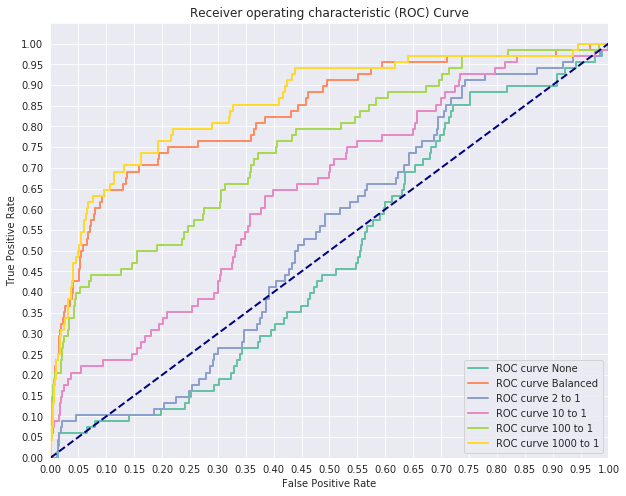

In [6]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, class_weight=weight,solver='lbfgs') #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

As you can see, class weight can have a significant impact! In this case, typically the heavier we weight the positive case, the better our classifier appears to be performing.

### Oversampling and Undersampling
Another technique that can be used is oversampling or undersampling. This can help address class imbalance problems when one category is far more prevalent than the other. This is a common case that occurs in medicine, image classification or fraud detection. In many of these scenarios, class imbalance can cause difficulties for the learning algorithm. After all, simply predicting the majority class could yield 99%+ accuracy if the rare class occurs <1% of the time. Due to this, sampling techniques such as oversampling the minority class or undersampling the majority class can help by producing a synthetic dataset that the learning algorithm is trained on. With this, it is important to still maintain a test set from the original dataset in order to accurately judge the accuracy of the algorithm overall.

Undersampling can only be used when you have a truly massive dataset and can afford to lose data points. However, even with very large data sets, you are losing potentially useful data. Oversampling can run into the issue of overfitting to certain characteristics of certain data points because there will be exact replicas of data points.

While these initial modifications will improve the performance of classification algorithms on imbalanced datasets, a more advanced technique known as SMOTE has produced even better results in practice.



#### SMOTE
SMOTE stands for Synthetic Minority Oversampling. Here, rather then simply oversampling the minority class with replacement (which simply adds duplicate cases to the dataset), the algorithm generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases. You can read more about SMOTE [here](https://jair.org/index.php/jair/article/view/10302/24590). 

SMOTE is generally a powerful way to deal with class imbalances, but it runs into computational issues when you have a large number of features due to the curse of dimensionality.
   
   Implementing this technique is very easy using the **imblearn** package:

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
print(y.value_counts()) #Previous original class distribution
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

0    99773
1      227
Name: is_attributed, dtype: int64
1    74841
0    74841
dtype: int64


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.1: 0.7199966261171564
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.25: 0.765787058446032
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.33: 0.7824930870792084
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,


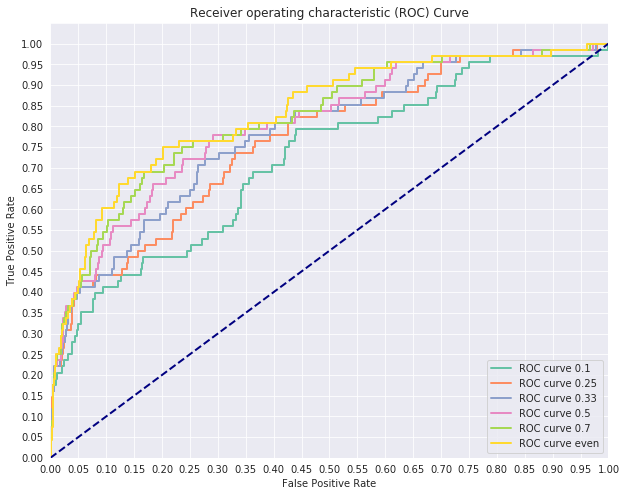

In [10]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1,0.25, 0.33, 0.5,0.7,1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, ratio in enumerate(ratios):
    #Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
    logreg = LogisticRegression(fit_intercept = False, C = 1e12,solver ='lbfgs') #Starter code
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Hopefully this should make sense; after synthetically resampling our data, we no longer need to lean on penalized class weights in order to improve our model tuning. Since SMOTE recreated our dataset to have a balanced number of positive and negative cases, aggressive weighting schemas such as 10:1, 100:1 or 1000:1 drastically impact our model performance; the data is effectively no longer class imbalanced, so creating the class weights effectively reintroduces the original problem. Overall, our SMOTE unweighted model appears to be the current top performer. In practice, it is up to you the modeler, to make this and other choices when comparing models. For example, you may also wish to tune other parameters in your model such as how to perform regularization.   

As a review, recall that regularization terms are penalties to a more straightforward error expression between our model and its outputs. The two most common regularizations are the l1 lasso and l2 ridge penalties. These add additional complexity to the loss function. In scikit-learn, these can be specified when initializing your regression object as in:
```logreg = LogisticRegression(penalty='l1')```

The default is to use an l2 penalty, so unless you specified otherwise, that's what you've been using.   

In addition to simply specifying how to regularize the model, you can also specify the amount of regularization. This is controlled through the C parameter. For example, here is the ROC curve of various regularization values with no corrections for class imbalance:

<img src="./images/roc_regularization.png">

As you can see, all of these models perform poorly regardless of the amount of regularization. 

## Summary
In this lesson, we investigated various tuning parameters for our model, as well as dealing with class imbalance as a whole. In the upcoming lab, you'll have a chance to try and adjust these parameters yourself in order to optimize a model for predicting credit fraud.